In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path)

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [8]:
TRAIN_SPLIT = 300000

In [9]:
tf.random.set_seed(13)

# Part 1: Forecast a Univariate Time Series

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ee3db10>],
      dtype=object)

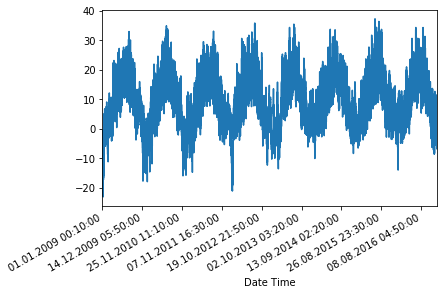

In [11]:
uni_data.plot(subplots=True)

In [12]:
uni_data = uni_data.values

In [13]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [14]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [15]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [33]:
print ('Single window of past history')
print (x_train_uni[2])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]
 [-2.09492208]]

 Target temperature to predict
-2.1041848598100876


In [17]:
def create_time_steps(length):
    return list(range(-length, 0))

In [18]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

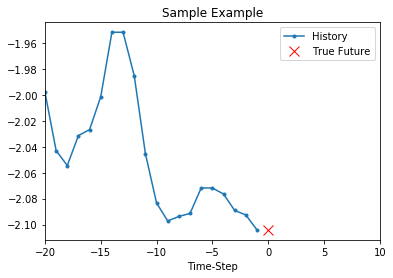

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [20]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

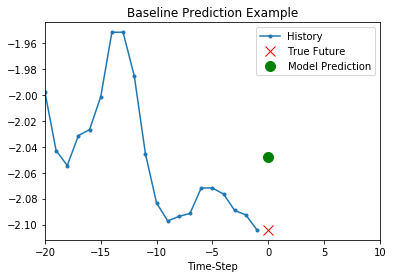

In [21]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [25]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 12s 60ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 7/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==========================

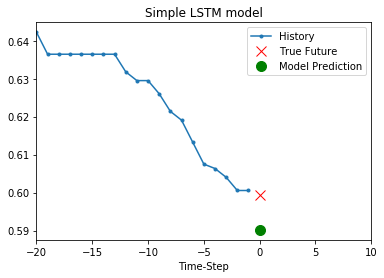

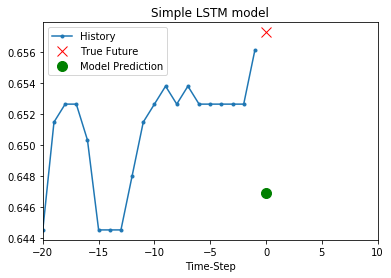

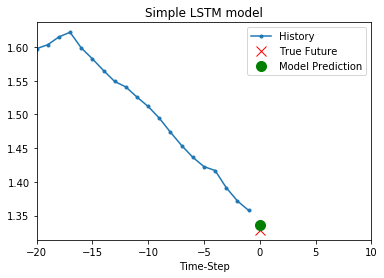

In [29]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# Forecast a Multivariate Time Series

In [37]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [38]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x65480a650>,
      dtype=object)

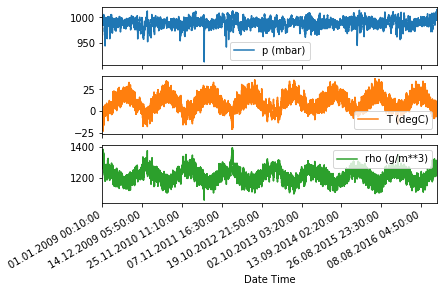

In [39]:
features.plot(subplots=True)

In [40]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [41]:
dataset = (dataset-data_mean)/data_std

In [43]:
dataset.shape

(420551, 3)

In [66]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [67]:
past_history = 720
future_target = 72
STEP = 6


x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [68]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [69]:
x_train_single.shape

(299280, 120, 3)

In [70]:
y_train_single.shape

(299280,)

In [71]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [74]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, activation='relu',
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [75]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [76]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=10,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 10 steps, validate for 50 steps
Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 0.4187 - val_loss: 0.4517
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.3805 - val_loss: 0.4188
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.3970 - val_loss: 0.3845
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.3964 - val_loss: 0.3097
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.3949 - val_loss: 0.2928
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.3560 - val_loss: 0.2953
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 0.3650 - val_loss: 0.2839
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 0.3500 - val_loss: 0.3083
Epoch 9/10
10/10 [==============================] - 12s 1s/step - loss: 0.3477 - val_loss: 0.2961
Epoch 10/10
10/10 [==============================] - 13s 1s/step - loss: 0.3

In [80]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

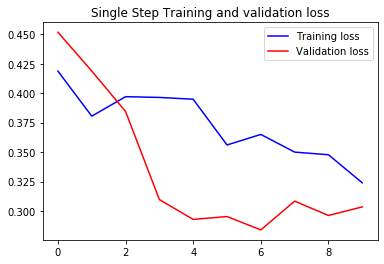

In [81]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

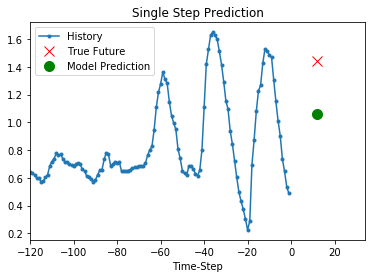

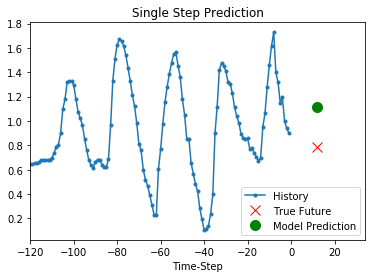

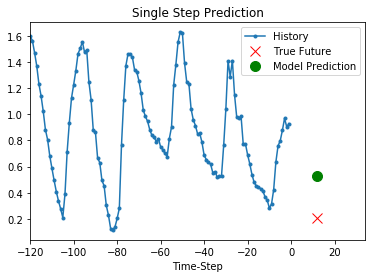

In [82]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

# Multi-step Model

In [83]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [84]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [85]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [86]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

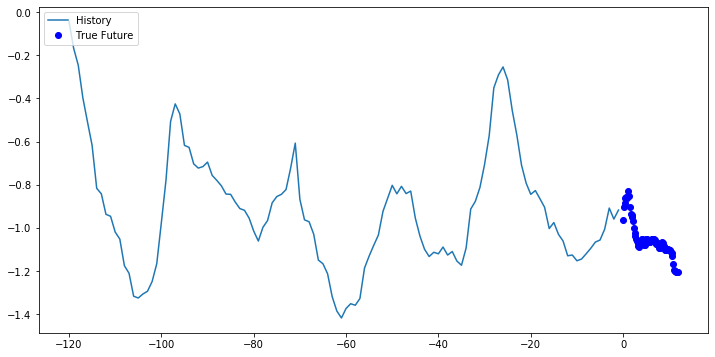

In [87]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [88]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [89]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 137s 686ms/step - loss: 0.4964 - val_loss: 0.3059
Epoch 2/10
114/200 [================>.............] - ETA: 1:54 - loss: 0.3635

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])